# Main imports and code

In [1]:
# check which gpu we're using
!nvidia-smi

Sat Feb 26 13:12:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:00:05.0 Off |                  N/A |
| 46%   33C    P8     5W / 105W |      0MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install simpletransformers tensorflow
!pip install tensorboardx

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 248 kB 16.4 MB/s eta 0:00:01
     |████████████████████████████████| 497.6 MB 27.2 MB/s eta 0:00:01     |████████████▎                   | 190.3 MB 20.1 MB/s eta 0:00:16
     |████████████████████████████████| 6.8 MB 28.6 MB/s eta 0:00:01
     |████████████████████████████████| 311 kB 31.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.7 MB 27.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 32.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 29.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 29.2 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 41.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 33.1 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 31.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 28.8 MB/s eta 0:00:01
     |███████████████████████

In [3]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

In [4]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [5]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2022-02-26 13:14:29.325853: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-26 13:14:29.327245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 13:14:29.328399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 13:14:29.329348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Fetch Don't Patronize Me! data manager module

In [7]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [8]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [9]:
from dont_patronize_me import DontPatronizeMe

In [10]:
dpm = DontPatronizeMe('.', '.')

In [11]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


# Load paragraph IDs

In [12]:
trids = pd.read_csv('./practice_splits/train_semeval_parids-labels.csv')
teids = pd.read_csv('./practice_splits/dev_semeval_parids-labels.csv')

In [13]:
trids.head()

par_id                  label
0    4341  [1, 0, 0, 1, 0, 0, 0]
1    4136  [0, 1, 0, 0, 0, 0, 0]
2   10352  [1, 0, 0, 0, 0, 1, 0]
3    8279  [0, 0, 0, 1, 0, 0, 0]
4    1164  [1, 0, 0, 1, 1, 1, 0]

In [14]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)



# Rebuild training set (Task 1)

In [15]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [16]:
trdf1 = pd.DataFrame(rows)

In [17]:
trdf1.head()

par_id                                               text  label
0   4341  The scheme saw an estimated 150,000 children f...      1
1   4136  Durban 's homeless communities reconciliation ...      1
2  10352  The next immediate problem that cropped up was...      1
3   8279  Far more important than the implications for t...      1
4   1164  To strengthen child-sensitive social protectio...      1

In [18]:
trdf1.shape[0]

8375

In [19]:
trdf1["label"].value_counts()

0    7581
1     794
Name: label, dtype: int64

**Discussion regarding Analysis of class labels**

The dataset is a skewed dataset, with 10 times more sentences not exhibiting pcl compared to sentences exhibiting pcl.

In [20]:
!pip install py-readability-metrics
!python -m nltk.downloader punkt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/opt/conda/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [21]:
from readability import Readability

def calculate_readability(text):
    try:
        r = Readability(text)
        return r.flesch_kincaid().score
    except:
        return 0

In [22]:
paragraphs = trdf1["text"]

trdf1["num_sentences_in_paragraph"] = paragraphs.apply(lambda x: len(x.split(".")))

trdf1.head()

par_id                                               text  label  \
0   4341  The scheme saw an estimated 150,000 children f...      1   
1   4136  Durban 's homeless communities reconciliation ...      1   
2  10352  The next immediate problem that cropped up was...      1   
3   8279  Far more important than the implications for t...      1   
4   1164  To strengthen child-sensitive social protectio...      1   

   num_sentences_in_paragraph  
0                           2  
1                           1  
2                           3  
3                           2  
4                           2

In [23]:

trdf1["readability_score"] = trdf1["text"].apply(lambda x: calculate_readability(x))

In [24]:
def avg_sentence_length(para):
    sentences = para.split(".")
    s_len = [len(s.split(" ")) for s in sentences]
    return sum(s_len) / len(s_len)


In [25]:
trdf1["avg_sentence_length"] = paragraphs.apply(lambda x : avg_sentence_length(x))

In [26]:
trdf1["readability_score"].describe()

count    8375.000000
mean        0.544217
std         2.946594
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        67.778221
Name: readability_score, dtype: float64

In [27]:
pat_sent = trdf1.loc[trdf1['label'] == 1]
non_pat_sent = trdf1.loc[trdf1['label'] == 0]

pat_sent.head()

par_id                                               text  label  \
0   4341  The scheme saw an estimated 150,000 children f...      1   
1   4136  Durban 's homeless communities reconciliation ...      1   
2  10352  The next immediate problem that cropped up was...      1   
3   8279  Far more important than the implications for t...      1   
4   1164  To strengthen child-sensitive social protectio...      1   

   num_sentences_in_paragraph  readability_score  avg_sentence_length  
0                           2                0.0            18.500000  
1                           1                0.0             6.000000  
2                           3                0.0            24.666667  
3                           2                0.0            23.000000  
4                           2                0.0            25.000000

In [28]:
import matplotlib.pyplot as plt
import numpy as np

INFO:matplotlib.font_manager:generated new fontManager


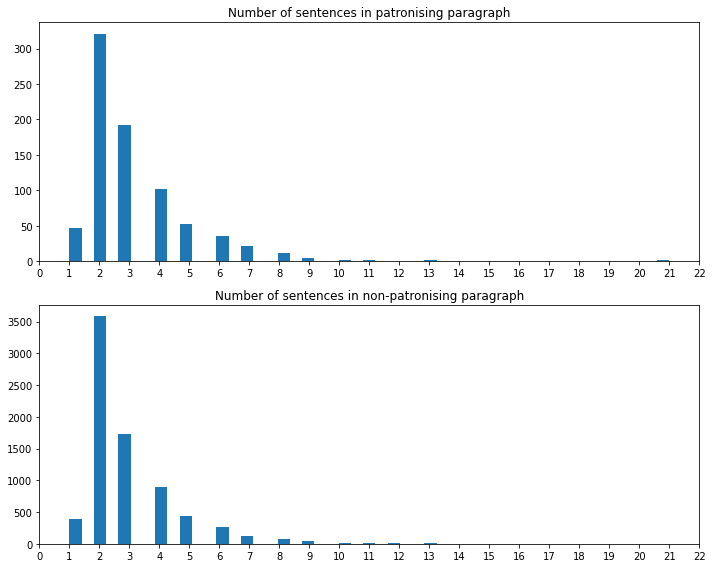

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(pat_sent["num_sentences_in_paragraph"], bins=np.linspace(1, 21))
ax1.xaxis.set_major_locator(plt.MultipleLocator(1))
ax1.set_title("Number of sentences in patronising paragraph")
ax2.hist(non_pat_sent["num_sentences_in_paragraph"], bins=np.linspace(1, 21))
ax2.xaxis.set_major_locator(plt.MultipleLocator(1))
ax2.set_title("Number of sentences in non-patronising paragraph")
fig.set_figwidth(10)
fig.set_figheight(8)
fig.tight_layout()
plt.show()
# ax.xaxis.set_major_locator()
# pat_sent.hist(grid=False,column="num_sentences_in_paragraph", bins=21, figsize=(10, 8), xticks=pat_sent["num_sentences_in_paragraph"], ax=ax)

In [30]:
trdf1[trdf1["avg_sentence_length"] == 133]

par_id                                               text  label  \
7590   7525  The Trawler : targets anyone with a Muslim con...      0   

      num_sentences_in_paragraph  readability_score  avg_sentence_length  
7590                           1          50.294912                133.0

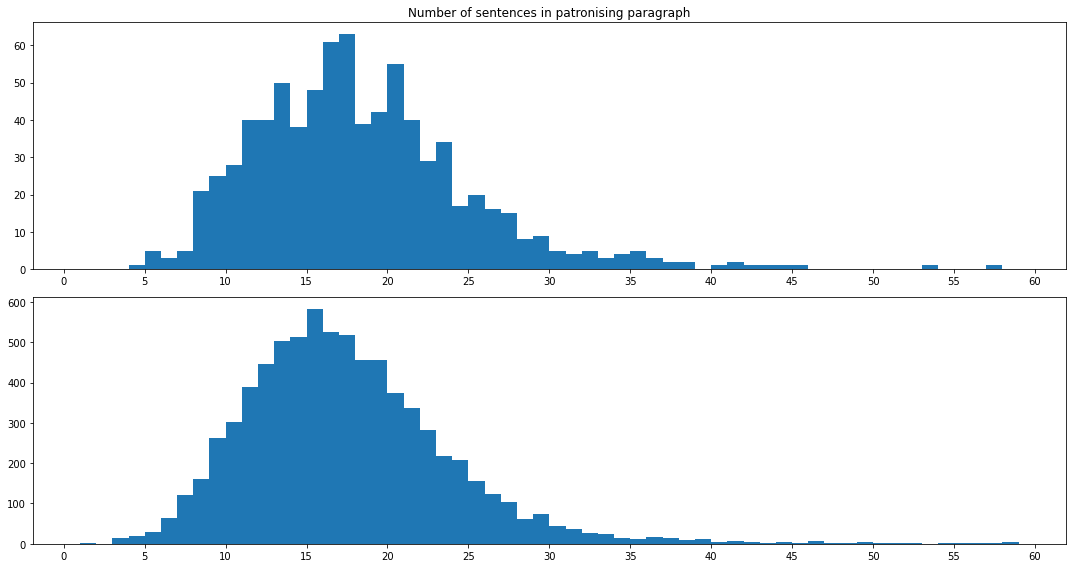

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(pat_sent["avg_sentence_length"], bins=np.arange(1, 60))
ax1.xaxis.set_major_locator(plt.MultipleLocator(5))
ax1.set_title("Number of sentences in patronising paragraph")
ax2.hist(non_pat_sent["avg_sentence_length"], bins=np.arange(1, 60))
ax2.xaxis.set_major_locator(plt.MultipleLocator(5))
# ax2.set_title("Number of sentences in non-patronising paragraph")
fig.set_figwidth(15)
fig.set_figheight(8)
fig.tight_layout()
plt.show()

### Synonym replacement

In [ ]:
!pip install nltk
import nltk
nltk.download('wordnet')

In [33]:
from nltk.corpus import wordnet

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [59]:
import random

def synonym_replacement(text):
    sentences = text.split(".")
    new_sentences = []
    for sent in sentences:
        words = sent.split(' ')
        synonyms = list(map(lambda w: get_synonyms(w), words))
        non_empty_synonyms_indices = [i for i, arr in enumerate(synonyms) if len(arr) != 0]
        indices = random.sample(non_empty_synonyms_indices, random.randint(0, len(non_empty_synonyms_indices)))
        for i in indices:
            words[i] = random.choice(synonyms[i])
        new_sentences.append(' '.join(words))
    return '.'.join(new_sentences)

In [62]:
trdf1_synonym = trdf1.copy()
for _ in range(9):
    pat_sent_synonym = trdf1.loc[trdf1['label'] == 1].copy()
    pat_sent_synonym['text'] = pat_sent_synonym['text'].apply(lambda x: synonym_replacement(x))
    trdf1_synonym = pd.concat([trdf1_synonym, pat_sent_synonym], ignore_index=True)

In [65]:
trdf1_synonym['label'].value_counts()

1    7940
0    7581
Name: label, dtype: int64

## Translation

In [64]:
# import googletrans
import random
# import translate
import deep_translator

def translate(source_text):
    language_opts = ['fr', 'es', 'da', 'eo', 'ht', 'ga', 'it', 'no', 'ru', 'sv', 'tr', 'ts', 'ta', 'sq', 'be', 'bg', 'nl'] # change to restrict language choices
    # print(language_opts)
    from_lang = 'en'
    to_lang = random.choice(list(language_opts))
    # to_lang='ta'
    print(to_lang)
    translator_to = deep_translator.GoogleTranslator(source=from_lang, target=to_lang)
    translator_from = deep_translator.GoogleTranslator(source=to_lang, target=from_lang)
    translated_sent = translator_to.translate(source_text)
    retranslated_sent = translator_from.translate(translated_sent)
    return retranslated_sent

sent = "This is a simple, yet powerful command line translator with google translate behind it. You can also use it as a Python module in your code. "

for _ in range(7):
    sent = translate(sent)
print(sent)

es
it
ta
eo
ga
sv
eo
I will keep my anger as long as I can, but I will pour out my wrath on you like a thousand waves! Stay out, you bastard! Leave me alone! Start a car? This car is a finished car! Abduction of the gods! God now! I am free, and my anger knows no bounds!


# Rebuild test set (Task 1)

In [66]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [67]:
len(rows)

2094

In [68]:
tedf1 = pd.DataFrame(rows)

# RoBERTa Baseline for Task 1

In [69]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [70]:
training_set1

par_id                                               text  label  \
0      4341  The scheme saw an estimated 150,000 children f...      1   
1      4136  Durban 's homeless communities reconciliation ...      1   
2     10352  The next immediate problem that cropped up was...      1   
3      8279  Far more important than the implications for t...      1   
4      1164  To strengthen child-sensitive social protectio...      1   
...     ...                                                ...    ...   
2377   1775  Last but not the least element of culpability ...      0   
2378   1776  Then , taking the art of counter-intuitive non...      0   
2379   1777  Kagunga village was reported to lack necessary...      0   
2380   1778  "After her parents high-profile divorce after ...      0   
2381   1779  "Last night One News reported on leaked Minist...      0   

      num_sentences_in_paragraph  readability_score  avg_sentence_length  
0                              2                0.0            18.500000  
1                              1                0.0             6.000000  
2                              3                0.0            24.666667  
3                              2                0.0            23.000000  
4                              2                0.0            25.000000  
...                          ...                ...                  ...  
2377                           2                0.0            12.500000  
2378                           2                0.0            23.500000  
2379                           3                0.0            13.333333  
2380                           2                0.0            38.000000  
2381                           2                0.0            20.500000  

[2382 rows x 6 columns]

In [ ]:
## Normal training
task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)
task1_model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

In [ ]:
Counter(preds_task1)

Counter({0: 1651, 1: 443})

In [ ]:
labels2file([[k] for k in preds_task1], 'task1.txt')

### Train with synonym replacement

In [72]:
training_set1_synonyms = trdf1_synonym
training_set1_synonyms

par_id                                               text  label  \
0       4341  The scheme saw an estimated 150,000 children f...      1   
1       4136  Durban 's homeless communities reconciliation ...      1   
2      10352  The next immediate problem that cropped up was...      1   
3       8279  Far more important than the implications for t...      1   
4       1164  To strengthen child-sensitive social protectio...      1   
...      ...                                                ...    ...   
15516    873  cite the fact that these kids world health org...      1   
15517  10070  Fern ? ndez was a well-known philanthropist wo...      1   
15518   6484  touch on a lot away their predicament , comman...      1   
15519   6249  She iterate her ministry 's commitment to put ...      1   
15520   5149  preach the sermon , the Dean of the St. Peter ...      1   

       num_sentences_in_paragraph  readability_score  avg_sentence_length  
0                               2                0.0            18.500000  
1                               1                0.0             6.000000  
2                               3                0.0            24.666667  
3                               2                0.0            23.000000  
4                               2                0.0            25.000000  
...                           ...                ...                  ...  
15516                           2                0.0            31.500000  
15517                           2                0.0            19.500000  
15518                           2                0.0            27.500000  
15519                           2                0.0            18.500000  
15520                           4                0.0            15.750000  

[15521 rows x 6 columns]

In [73]:
task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)
task1_model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1_synonyms[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

DEBUG:filelock:Attempting to acquire lock 139946483054384 on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
DEBUG:filelock:Lock 139946483054384 acquired on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139946483054384 on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
DEBUG:filelock:Lock 139946483054384 released on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
DEBUG:filelock:Attempting to acquire lock 139946480692576 on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
DEBUG:filelock:Lock 139946480692576 acquired on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139946480692576 on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
DEBUG:filelock:Lock 139946480692576 released on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139948825858928 on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
DEBUG:filelock:Lock 139948825858928 released on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
DEBUG:filelock:Attempting to acquire lock 139948825440848 on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
DEBUG:filelock:Lock 139948825440848 acquired on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139948825440848 on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
DEBUG:filelock:Lock 139948825440848 released on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
DEBUG:filelock:Attempting to acquire lock 139946483054384 on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
DEBUG:filelock:Lock 139946483054384 acquired on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139946483054384 on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
DEBUG:filelock:Lock 139946483054384 released on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
/opt/conda/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:585: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/15521 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1941 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [74]:
Counter(preds_task1)

Counter({0: 1996, 1: 98})

In [79]:
test_labels = tedf1.label.to_list()
correct = 0
for i in range(len(preds_task1)):
    correct += preds_task1[i] == test_labels[i]
correct / len(preds_task1)

0.9135625596943648

# Rebuild training set (Task 2)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  label = trids.label[idx]
  # select row from original dataset to retrieve the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
trdf2 = pd.DataFrame(rows2)

In [ ]:
trdf2

par_id  ...                  label
0      4341  ...  [1, 0, 0, 1, 0, 0, 0]
1      4136  ...  [0, 1, 0, 0, 0, 0, 0]
2     10352  ...  [1, 0, 0, 0, 0, 1, 0]
3      8279  ...  [0, 0, 0, 1, 0, 0, 0]
4      1164  ...  [1, 0, 0, 1, 1, 1, 0]
...     ...  ...                    ...
8370   8380  ...  [0, 0, 0, 0, 0, 0, 0]
8371   8381  ...  [0, 0, 0, 0, 0, 0, 0]
8372   8382  ...  [0, 0, 0, 0, 0, 0, 0]
8373   8383  ...  [0, 0, 0, 0, 0, 0, 0]
8374   8384  ...  [0, 0, 0, 0, 0, 0, 0]

[8375 rows x 3 columns]

In [ ]:
trdf2.label = trdf2.label.apply(literal_eval)

# Rebuild test set (Task 2)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  label = teids.label[idx]
  #print(parid)
  # select row from original dataset to access the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
tedf2 = pd.DataFrame(rows2)

In [ ]:
tedf2

par_id  ...                  label
0      4046  ...  [1, 0, 0, 1, 0, 0, 0]
1      1279  ...  [0, 1, 0, 0, 0, 0, 0]
2      8330  ...  [0, 0, 1, 0, 0, 0, 0]
3      4063  ...  [1, 0, 0, 1, 1, 1, 0]
4      4089  ...  [1, 0, 0, 0, 0, 0, 0]
...     ...  ...                    ...
2089  10462  ...  [0, 0, 0, 0, 0, 0, 0]
2090  10463  ...  [0, 0, 0, 0, 0, 0, 0]
2091  10464  ...  [0, 0, 0, 0, 0, 0, 0]
2092  10465  ...  [0, 0, 0, 0, 0, 0, 0]
2093  10466  ...  [0, 0, 0, 0, 0, 0, 0]

[2094 rows x 3 columns]

In [ ]:
tedf2.label = tedf2.label.apply(literal_eval)

# RoBERTa baseline for Task 2

In [ ]:
all_negs = trdf2[trdf2.label.apply(lambda x:sum(x) == 0)]
all_pos = trdf2[trdf2.label.apply(lambda x:sum(x) > 0)]

training_set2 = pd.concat([all_pos,all_negs[:round(len(all_pos)*0.5)]])

In [ ]:
training_set2

par_id  ...                  label
0      4341  ...  [1, 0, 0, 1, 0, 0, 0]
1      4136  ...  [0, 1, 0, 0, 0, 0, 0]
2     10352  ...  [1, 0, 0, 0, 0, 1, 0]
3      8279  ...  [0, 0, 0, 1, 0, 0, 0]
4      1164  ...  [1, 0, 0, 1, 1, 1, 0]
...     ...  ...                    ...
1186    434  ...  [0, 0, 0, 0, 0, 0, 0]
1187    435  ...  [0, 0, 0, 0, 0, 0, 0]
1188    436  ...  [0, 0, 0, 0, 0, 0, 0]
1189    437  ...  [0, 0, 0, 0, 0, 0, 0]
1190    439  ...  [0, 0, 0, 0, 0, 0, 0]

[1191 rows x 3 columns]

In [ ]:
task2_model_args = MultiLabelClassificationArgs(num_train_epochs=1,
                                                no_save=True, 
                                                no_cache=True, 
                                                overwrite_output_dir=True
                                                )
task2_model = MultiLabelClassificationModel("roberta", 
                                            'roberta-base', 
                                            num_labels=7,
                                            args = task2_model_args, 
                                            use_cuda=cuda_available)
# train model
task2_model.train_model(training_set2[['text', 'label']])
# run predictions
preds_task2, _ = task2_model.predict(tedf2.text.tolist())

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias',

  0%|          | 0/1191 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/149 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
labels2file(preds_task2, 'task2.txt')

## Prepare submission

In [ ]:
!cat task1.txt | head -n 10

1
1
0
1
0
0
1
1
0
1


In [ ]:
!cat task2.txt | head -n 10

1,0,0,0,0,0,0
1,0,0,0,0,0,0
0,0,0,0,0,0,0
1,0,0,0,0,1,0
0,0,0,0,0,0,0
0,0,0,0,0,0,0
1,0,0,0,0,0,0
1,0,0,0,0,0,0
0,0,0,0,0,0,0
0,0,1,0,0,1,0


In [ ]:
!zip submission.zip task1.txt task2.txt

  adding: task1.txt (deflated 92%)
  adding: task2.txt (deflated 97%)
